# test inference pipeline on low noise $(M_{\rm UV}, z)$ 
test of 
- the selection function
- monte carlo integral

In [1]:
import os
import numpy as np 
from astropy import units as u
from astropy.cosmology import Planck13

In [2]:
import emcee

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read true $(M_{\rm UV}, z)$

In [5]:
mock_ztrue, mock_Muvtrue, _, _, _, _, w_z, w_muv = np.loadtxt('/Users/chahah/data/binsin/mock0.dat',unpack=True, skiprows=1)

In [6]:
w_select = w_z * w_muv

(-14.0, -22.0)

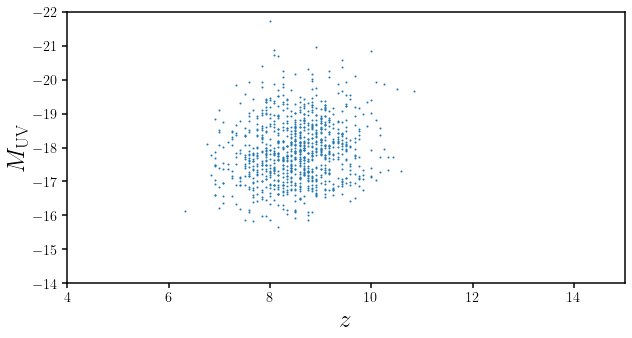

In [8]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(mock_ztrue, mock_Muvtrue, s=1)
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

# set up selection function 

In [11]:
bx = np.load('/Users/chahah/data/binsin/mock0_selection.bx.npy')
by = np.load('/Users/chahah/data/binsin/mock0_selection.by.npy')
ptS = np.load('/Users/chahah/data/binsin/mock0_selection.p_theta_S.npy')

In [20]:
def p_theta_S(Muv, z): 
    i_x = np.digitize(Muv, by)
    i_y = np.digitize(z, bx)
    return ptS[i_x-1, i_y-1]

(-15.0, -22.0)

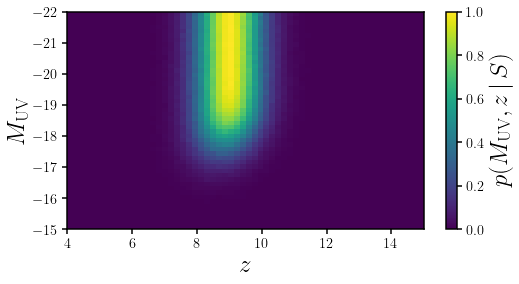

In [14]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
X, Y = np.meshgrid(bx, by)

p = sub.pcolormesh(X, Y, ptS, vmin=0., vmax=1)

plt.colorbar(p).set_label(r'$p(M_{\rm UV}, z\,|\,S)$', size=25)
sub.set_xlabel('$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_ylim(-15, -22)

# set up  posterior
$$p(\phi\,|\,\{X_i\},S) \approx p(\phi\,|\,S) \prod\limits_{i=1}^{N} \frac{p(\theta_{i}\,|\,\phi, S)}{p(\theta_{i}\,|\,S)}$$
$$\log p(\phi\,|\,\{X_i\},S) \approx {\rm constant} + \log p(\phi\,|\,S) + \sum\limits_{i=1}^{N} \log \frac{\Phi(\theta_{i};\phi)/\int\Phi(\theta';\phi) S(\theta'){\rm d}\theta'}{p(\theta_{i}\,|\,S)}$$

In [15]:
def LF(Muv, z, phi): 
    alpha, beta, gamma, Muv_s = phi
    return (10**(gamma * (z - 9.)))/(10**(0.4*(alpha + 1)*(Muv - Muv_s) + 10**(0.4*(beta + 1)*(Muv - Muv_s))))

/opt/anaconda3/envs/uhod/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


(0.0, 0.5)

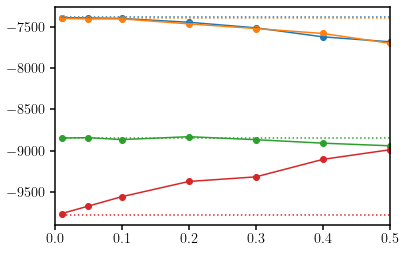

In [25]:
n_mcmc = 100
phis = [np.array([-1.65, -1.5, -0.2, -19.5]), 
        np.array([-1.5,  -1.33, -0.2, -17.98954929]), 
        np.array([-0.001, -1.45, -0.05, -20]), 
        np.array([-2.99, -2.8, -0.98, -19])]

fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)
for i, phi in enumerate(phis): 
    sigs = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5])
    unif = np.array([4., -22])[None,:] + np.array([10, 7])[None,:] * np.random.uniform(size=(100000, 2))
    unif_S = p_theta_S(unif[:,1], unif[:,0])

    norm_Phi = np.sum(LF(unif[:,1], unif[:,0], phi) * unif_S)

    Phi = LF(mock_Muvtrue, mock_ztrue, phi) * p_theta_S(mock_Muvtrue, mock_ztrue) / norm_Phi
    within = (Phi > 0.)
    logp = np.sum((np.log(Phi) - np.log(w_select))[within], axis=0)

    sub.plot(sigs, np.repeat(logp, len(sigs)), c='C%i' % i, ls=':')
    
    logps = []
    for sig in sigs: 
        mock_z = mock_ztrue + sig * np.random.normal(size=len(mock_ztrue))
        mock_Muv = mock_Muvtrue + sig * np.random.normal(size=len(mock_ztrue))
        
        posteriors = np.zeros((len(mock_ztrue), 2, n_mcmc))
        posteriors[:,0,:] = (mock_z[:,None] + sig * np.random.normal(size=(len(mock_ztrue), n_mcmc))).clip(4., 15.)
        posteriors[:,1,:] = (mock_Muv[:,None] + sig * np.random.normal(size=(len(mock_ztrue), n_mcmc))).clip(-22., -15)      

        mock_S = p_theta_S(posteriors[:,1,:], posteriors[:,0,:])
        Phi = LF(posteriors[:,1,:], posteriors[:,0,:], phi) * mock_S / norm_Phi
        
        p_Xi_phiS = np.sum(Phi, axis=1) / n_mcmc
        within = (p_Xi_phiS > 0)
        
        logp = np.sum(np.log(p_Xi_phiS[within]) - np.log(w_select[within]), axis=0)
        logps.append(logp)
    sub.scatter(sigs, logps, c='C%i' % i)
    sub.plot(sigs, logps, c='C%i' % i)
sub.set_xlim(0., 0.5)

In [26]:
n_mcmc = 1000
sig = 0.1

mock_z = mock_ztrue + sig * np.random.normal(size=len(mock_ztrue))
mock_Muv = mock_Muvtrue + sig * np.random.normal(size=len(mock_ztrue))

posteriors = np.zeros((len(mock_ztrue), 2, n_mcmc))
posteriors[:,0,:] = (mock_z[:,None] + sig * np.random.normal(size=(len(mock_ztrue), n_mcmc))).clip(4., 15.)
posteriors[:,1,:] = (mock_Muv[:,None] + sig * np.random.normal(size=(len(mock_ztrue), n_mcmc))).clip(-22., -15)      

In [27]:
unif = np.array([4., -22])[None,:] + np.array([10, 7])[None,:] * np.random.uniform(size=(100000, 2))
unif_S = p_theta_S(unif[:,1], unif[:,0])

post_S = p_theta_S(posteriors[:,1,:], posteriors[:,0,:])

within = (np.sum(post_S, axis=1) > 0)

In [28]:
def log_prior(phi): 
    alpha, beta, gamma, Muv_s = phi
    if -3. < alpha < 1. and -3. < beta < 1. and -1. < gamma < 1. and -22 < Muv_s < -15: 
        return 0.
    return -np.inf

def log_posterior(phi): 
    lp = log_prior(phi)
    if not np.isfinite(lp):
        return -np.inf

    Phi = LF(posteriors[:,1,:], posteriors[:,0,:], phi)
    norm_Phi = np.sum(LF(unif[:,1], unif[:,0], phi) * unif_S)
    
    p_Xi_phiS = np.sum(Phi *post_S / norm_Phi, axis=1)/float(n_mcmc)

    logp = np.sum(np.log(p_Xi_phiS[within]) - np.log(w_select[within]), axis=0)
    if np.isnan(logp): raise ValueError
    return logp

In [29]:
log_posterior([-1.65, -1.5, -0.2, -19.5]), log_posterior([-1.5,  -1.33, -0.2, -17.98954929]), log_posterior([-1.21126749, -1.39672104, -0.14763412, -19.5]), log_posterior([-0.001, -1.45, -0.05, -20]), log_posterior([-2.99, -2.8, -0.98, -19])

(-7419.5896707286765,
 -7418.521391277016,
 -7539.2260579732665,
 -8875.224292185347,
 -9532.757387202391)

In [30]:
ndim, nwalkers = 4, 20
var = np.array([0.1, 0.1, 0.1, 0.1])
p0 = np.array([-1.2, -1.4, -0.15, -19.4])[None,:] + var[None,:]*np.random.randn(nwalkers, ndim)

In [31]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
_ = sampler.run_mcmc(p0, 2000, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [53:50<00:00,  1.62s/it]


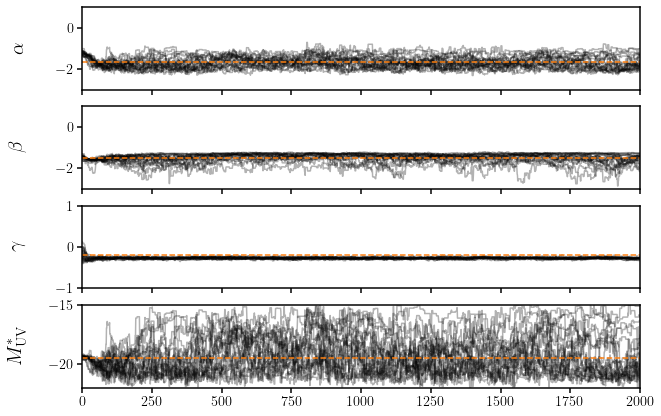

In [32]:
phi_true = np.array([-1.65, -1.5, -0.2, -19.5])

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.plot([0, samples.shape[0]], [phi_true[i], phi_true[i]], c='C1', ls='--')
    ax.set_xlim(0, len(samples))
    ax.set_ylabel([r'$\alpha$', r'$\beta$', r'$\gamma$', r'$M_{\rm UV}^*$'][i], fontsize=20)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_ylim([(-3., 1.), (-3., 1.), (-1., 1.), (-22, -15)][i])

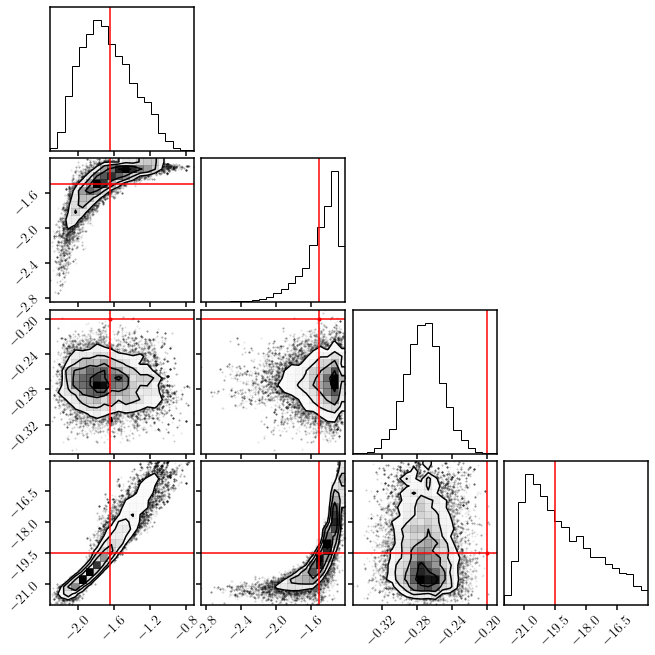

In [36]:
fig = DFM.corner(sampler.flatchain[1000:,:])
DFM.overplot_points(fig, [phi_true], color='red')
DFM.overplot_lines(fig, phi_true, color='red')

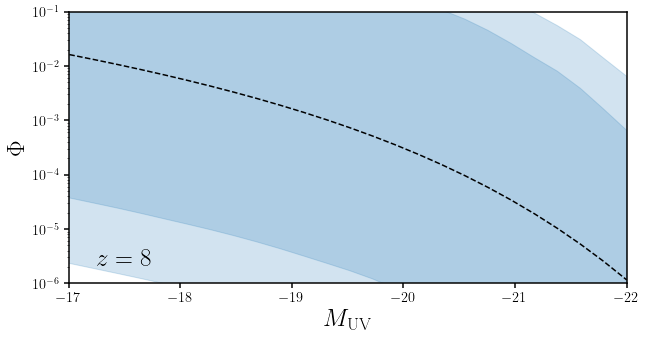

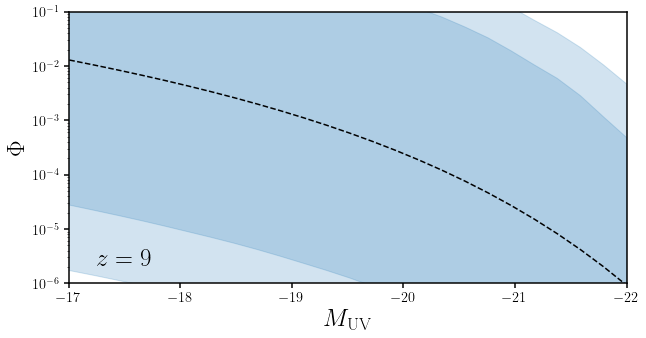

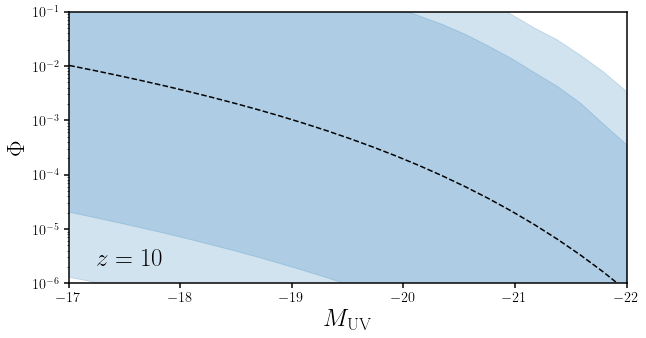

In [35]:
phi_amp = 6e-3
norm_Phi_true = np.sum(LF(unif[:,1], unif[:,0], phi_true) * unif_S)

muv = np.linspace(-16, -22, 30)

for z in [8.5, 9, 9.5]: 
    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(111)

    
    lf = phi_amp * LF(muv, z, phi_true)
    #muv, lf = bLF.lf_zeus21(z)
    
    lfs = []
    for phi in sampler.flatchain[nwalkers*-200:,:]:
        _phi_amp = phi_amp / norm_Phi_true * np.sum(LF(unif[:,1], unif[:,0], phi) * unif_S)    
        lfs.append(_phi_amp * LF(muv, z, phi))

    q0, q1, q2, q3 = np.quantile(np.array(lfs), [0.025, 0.16, 0.84, 0.975], axis=0)

    sub.fill_between(muv, q0, q3, color='C0', alpha=0.2)
    sub.fill_between(muv, q1, q2, color='C0', alpha=0.2)
    sub.plot(muv, lf, c='k', ls='--')
    
    sub.text(0.05, 0.05, r'$z=%.f$' % z, fontsize=25, transform=sub.transAxes, ha='left', va='bottom')
    sub.set_xlabel(r'$M_{\rm UV}$', fontsize=25)
    sub.set_xlim(-17, -22)
    sub.set_ylabel(r'$\Phi$', fontsize=25)
    sub.set_yscale('log')
    sub.set_ylim(1e-6, 1e-1)#sub.set_ylim(0.1, 4e2)
    #sub.set_ylim(0.1, 4e2)